In [143]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from constants import *
from scipy.special import k0

plt.style.use('./myplot.mplstyle')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
num_v = 20
v = np.linspace(-5, 5, num_v)
dv = v[1] - v[0]

In [3]:
VX, VY, VZ = np.meshgrid(v, v, v, indexing='ij')
V2 = np.sqrt(VX**2 + VY**2 + VZ**2)
V2 = V2.reshape(num_v**3)

In [4]:
rng = np.random.default_rng(0)
X = rng.normal(size=num_v**3)
Xn = rng.normal(size=num_v**3)
# Y = rng.normal(size=num_v**3)

In [5]:
freq = np.arange(1,10) * 1 / (20 * yr)

In [6]:
def ReRho(freq: list[float], m: float, sigma: float):
    '''
    Compute Re(rho_k)
    Input
        freq    (ndarray (n,))     frequency array
        m       (scalar)           mass [Hz]
        sigma   (scalar)           velocity dispersion [km/sec]
    '''
    
    Xtilde = X * np.exp(-V2 / 2)


    freq_diff = freq[:, None, None] + 0.5 * m * (sigma / c)**2 * (V2[None, :, None] - V2[None, None, :])
    kernel_ReRho = np.sinc(freq_diff * np.pi / freq[0])
    # freq_diff = freq + 0.5 * m * (sigma / c)**2 * (V2[:, None] - V2[None, :])
    # kernel_ReRho = np.sinc(freq_diff * np.pi / (1e-9))

    print(freq_diff.shape)
    
    return dv**3 / (2 * np.pi)**1.5 * Xtilde @ kernel_ReRho @ Xtilde.T

In [314]:
class ULDM_Signal:
    def __init__(self, mass, sigma, T, na):
        '''
        Initialize the instance

        Input
            mass    (scalar)        mass [Hz]
            sigma   (scalar)        vel. dispersion [km/sec]
            T       (scalar)        total observational time span [sec]
            na      (ndarray (3,))  unit vector along the line of sight
        '''

        self.tau = 1 / (mass * (sigma / c)**2)
        self.kin = 1 / self.tau
        self.rng = np.random.default_rng(0)
        self.na = na
        self.T = T

        self.set_arrays()
        self.set_kernel()
        
    def set_arrays(self, Nd=7, Nc=7, Nmu=5, Nphi=5):
        '''
        Set arrays for ULDM signal computation

        Input
            Nd  (scalar)    number of wd frequency bins
            Nc  (scalar)    number of wc frequency bins
            Nmu (scalar)    number of cos(theta) bins
            Nphi(scalar)    number of phi bins
        '''
        
        self.Nd = Nd
        self.Nc = Nc
        self.Nmu = Nmu
        self.Nphi = Nphi
        
        self.wd = 2 * np.pi / self.T * np.arange(1, Nd + 1)
        self.wc = np.linspace(np.pi / self.T, 30 * self.kin, Nc)
        self.cos = np.linspace(-1, 1, Nmu)
        self.phi = np.linspace(0, 2 * np.pi, Nphi)

        self.dwc = self.wc[1] - self.wd[0]
        self.dO = (self.cos[1] - self.cos[0]) * (self.phi[1] - self.phi[0])

        self.WC, self.COS1, self.PHI1, self.COS2, self.PHI2 = np.meshgrid(self.wc, 
                                                                          self.cos, 
                                                                          self.phi,
                                                                          self.cos,
                                                                          self.phi,
                                                                          indexing='ij')

    def set_kernel(self):
        self.kernel = [[] for _ in range(len(self.wd))]
        
        for idx, wd in enumerate(self.wd):
            self.kernel[idx] = self.compute_kernel(wd)

    def compute_kernel(self, wd: float):

        v1 = np.sqrt(self.WC + wd / 2)
        v2 = np.sqrt(self.WC - wd / 2, where=(self.WC - wd / 2 > 0), out=np.zeros(self.WC.shape))

        SIN1, SIN2 = np.sqrt(1 - self.COS1**2), np.sqrt(1 - self.COS2**2)

        v1_dot_v2 = self.COS1 * self.COS2 + np.cos(self.PHI1 - self.PHI2) * SIN1 * SIN2
        na_dot_v1 = self.na[0] * SIN1 * np.cos(self.PHI1) + self.na[1] * SIN1 * np.sin(self.PHI1) + self.na[2] * self.COS1
        na_dot_v2 = self.na[0] * SIN2 * np.cos(self.PHI2) + self.na[1] * SIN2 * np.sin(self.PHI2) + self.na[2] * self.COS2

        result = np.exp(-0.5 * self.WC * self.tau) * v1 * v2 * 1j * (na_dot_v1 * v1 - na_dot_v2 * v2) 
        result = result / (self.WC - v1 * v2 * v1_dot_v2)
        
        return result
    
    def delta_t(self):
        '''
        compute the Fourier component of the timing residual
        '''
        self.delta_t_arr = [[] for _ in range(self.Nd)]
        
        for idx in range(self.Nd):
            r1 = self.rng.rayleigh(size=(self.Nc, self.Nmu, self.Nphi))
            r2 = self.rng.rayleigh(size=(self.Nc, self.Nmu, self.Nphi))
            theta1 = self.rng.uniform(low=0, high=2*np.pi, size=(self.Nc, self.Nmu, self.Nphi))
            theta2 = self.rng.uniform(low=0, high=2*np.pi, size=(self.Nc, self.Nmu, self.Nphi))

            a1 = r1[:,:,:,None,None] * np.exp(+1j * theta1[:,:,:,None,None])
            a2 = r2[:,None,None,:,:] * np.exp(-1j * theta2[:,None,None,:,:])
            
            self.delta_t_arr[idx] = np.sum(a1 * self.kernel[idx] * a2) / self.wd[idx]**2 * self.dwc * self.dO

In [315]:
test = ULDM_Signal(mass=5e-2, sigma=160, T=30*yr, na=np.array([0,0,1]))
test.set_arrays(Nd=100, Nc=20, Nmu=10, Nphi=10)
test.set_kernel()

In [316]:
tmp = []
for i in range(5):
    test.delta_t()
    tmp.append(np.abs(test.delta_t_arr)**2)

In [317]:
aa = [np.mean(np.array(tmp)[:,i]) for i in range(len(tmp[0]))]

Text(0, 0.5, '$|\\widetilde{\\delta t}|^2$')

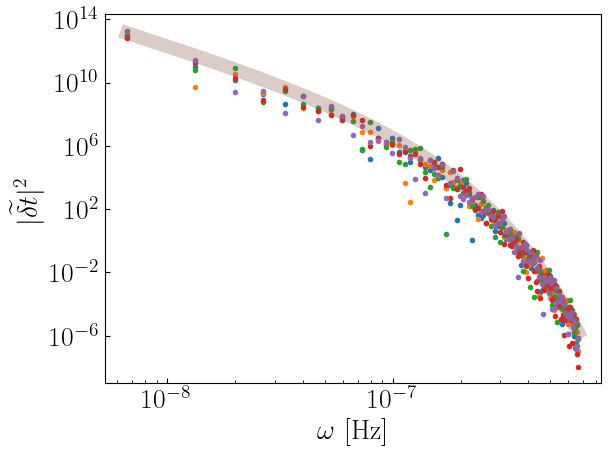

In [335]:
for i in range(len(tmp)):
    plt.plot(test.wd, tmp[i], '.')
plt.plot(test.wd, 1e-21 * s(test.wd / 2, test.tau),lw=10,alpha=0.3)
# plt.plot(test.wd, 1e+10 * k0(np.abs(test.wd * test.tau)) )
# plt.plot(test.wd, 1e-19/test.wd**4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\omega\,\,[\rm Hz]$')
plt.ylabel(r'$|\widetilde{\delta t}|^2$')

In [258]:
def s(w, tau):
    return 1/w**4 * k0(np.abs(w * tau))